# SCENIC - Template script

*Last updated*: 22 jan 2019

For a detailed tutorial with explanations see: https://pyscenic.readthedocs.io

The notebook `pySCENIC_template_DataPreparation_geneFilter.ipynb` provides a guide on how to prepare and filter the input data.

In [19]:
import os
import datetime
os.getcwd()
print(datetime.datetime.now().strftime("%Y %b %d (%H:%M)"))

'/ddn1/vol1/staging/leuven/stg_00002/lcb/saibar/Projects/runs_SCENIC/2019-01_pySCENIC_tutorial_wZeisel'

2019 Jan 25 (15:10)


Input files:

In [20]:
input_exprMat_path = os.path.join(os.getcwd(), 'filteredExpressionMatrix.loom')

### Databases (Select/adjust the organism & paths):
ORGANISM = 'mouse' # 'human' / 'mouse'/ 'drosophila'
DATABASE_FOLDER = '~/motif_databases/'
ANNOTATIONS_FOLDER = "~/motif_annotations/" 

if(ORGANISM == 'human'):
    MOTIF_ANNOTATIONS_FNAME = os.path.join(ANNOTATIONS_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
    DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "hg19-*.mc9nr.feather")
    #TFS_PATH = 'tfs_human.txt' # optional
if(ORGANISM == 'mouse'):
    MOTIF_ANNOTATIONS_FNAME = os.path.join(ANNOTATIONS_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")
    DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.mc9nr.feather")
    #TFS_PATH = 'tfs_mouse.txt' # optional
if(ORGANISM == 'drosophila'):
    MOTIF_ANNOTATIONS_FNAME = os.path.join(ANNOTATIONS_FOLDER, "motifs-v8-nr.flybase-m0.001-o0.0.tbl")
    DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "dm6-5kb-upstream-full-tx-11species.mc8nr.feather")
    #TFS_PATH = 'tfs_drosophila.txt' # optional

In [23]:
# Optional (description of the dataset for the loom file):
loom_title='Mouse brain (Zeisel et al. 3005 cells) - SCENIC', 
loom_tree_structure=(ORGANISM, 'Mouse Brain - SCENIC', '')

Output files (no need to modify):

In [22]:
OUT_FOLDER = "output"
os.makedirs(OUT_FOLDER, exist_ok=True)
LOOM_FNAME = os.path.join(OUT_FOLDER, "SCENIC.loom")
ADJACENCIES_FNAME = os.path.join(OUT_FOLDER, "adjacencies.tsv")
MODULES_FNAME = os.path.join(OUT_FOLDER, "modules.p")
MOTIFS_FNAME = os.path.join(OUT_FOLDER, "motifs.tsv")
REGULONS_FNAME = os.path.join(OUT_FOLDER, "regulons.p")
AUCMAT_FNAME = os.path.join(OUT_FOLDER, "aucMatrix.tsv")
UMAP_FNAME = os.path.join(OUT_FOLDER, "umap.tsv")
TSNE_FNAME = os.path.join(OUT_FOLDER, "tsne.tsv")

Setup cluster (optional):
> [Tutorials](https://arboreto.readthedocs.io/en/latest/examples.html#jupyter-notebooks) for runing Arboreto with Dask

In [ ]:
from distributed import LocalCluster, Client
customClient = Client('tcp://10.118.224.141:8786')
customClient

# Load data and databases

### Modules

In [25]:
import pandas as pd
import numpy as np
import os, glob
import pickle
import loompy

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, add_motif_url
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
from pyscenic.export import export_motifs2txt, export_asGmt, export2loom

In [5]:
!pip show arboreto | grep 'Version'

Version: 0.1.5


In [6]:
!pip show pyscenic | grep 'Version'

Version: 0.9.3+0.gca23423.dirty


In [7]:
!pip show loompy | grep 'Version'

Version: 2.0.2


### Expression matrix

Already filtered & transposed (rows: cells, columms: genes)

In [8]:
with loompy.connect(input_exprMat_path) as ds:
    ex_matrix=pd.DataFrame(ds[:,:], index=list(ds.ra['Gene']))
    ex_matrix.columns=list(ds.ca['CellID'])
    ex_matrix=ex_matrix.T
ex_matrix.shape
ex_matrix.iloc[:10,:5]

(3005, 13800)

,0610007P14Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010F05Rik
1772071015_C02,3,0,1,0,0
1772071017_G12,0,1,4,0,5
1772071017_A05,1,3,2,1,4
1772071014_B06,0,3,1,0,5
1772067065_H06,1,0,2,0,5
1772071017_E02,0,0,1,0,2
1772067065_B07,4,0,6,1,2
1772067060_B09,3,0,2,0,4
1772071014_E04,0,2,0,0,3
1772071015_D04,3,1,2,0,2


### Ranking databases

In [60]:
db_fnames=glob.glob(os.path.expanduser(DATABASES_GLOB))
db_fnames = [db for db in db_fnames if "regions" not in db]
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg19-500bp-upstream-7species"),
 FeatherRankingDatabase(name="hg19-tss-centered-10kb-10species"),
 FeatherRankingDatabase(name="hg19-tss-centered-5kb-7species"),
 FeatherRankingDatabase(name="hg19-tss-centered-5kb-10species"),
 FeatherRankingDatabase(name="hg19-tss-centered-10kb-7species"),
 FeatherRankingDatabase(name="hg19-500bp-upstream-10species")]

### List of Transcription Factors (TF)

> The list of potential regulators (e.g. all the transcription factors in the given organism) can be 
from a curated database (e.g. TFCat: [pySCENIC - Preliminary - Known TFs for Mus musculus as MGI symbols.ipynb](https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20Preliminary%20-%20Known%20TFs%20for%20Mus%20musculus%20as%20MGI%20symbols.ipynb), loaded with ` tf_names = load_tf_names(TFS_PATH) `), 
or all the genes/transcription factors in the annotation database (default in the R implementation of SCENIC):

In [10]:
tf_names = list(set(pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t', index_col=0)['gene_name']))
tf_names.sort()

/user/leuven/312/vsc31245/.conda/envs/pyscenic/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
len(tf_names)
tf_names[50:60]

1721

['Arg1',
 'Arg2',
 'Arid3a',
 'Arid3b',
 'Arid3c',
 'Arid5a',
 'Arid5b',
 'Arnt',
 'Arnt2',
 'Arntl']

In [12]:
# How many present in the filtered expression matrix?
tf_names = list(set(tf_names).intersection(set(ex_matrix.columns.values)))
tf_names.sort()
len(tf_names)

1157

# Phase I: Inference of co-expression modules

### Run GRNboost/GENIE3

> The [arboreto](https://arboreto.readthedocs.io) package is used for this phase of the pipeline.
> More details: [https://pyscenic.readthedocs.io](https://pyscenic.readthedocs.io/en/latest/#run-genie3-or-grnboost-from-arboreto-to-infer-co-expression-modules) and [notebooks/pySCENIC - Percentiles as threshold for modules.ipynb](https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20Percentiles%20as%20threshold%20for%20modules.ipynb).

Running status: http://localhost:8787/status

In [ ]:
#%%time
adjacencies = grnboost2(expression_data=ex_matrix, tf_names=tf_names, seed=123, client_or_address=customClient)

In [ ]:
adjacencies.shape
adjacencies.head()

In [ ]:
# Save
adjacencies.to_csv(ADJACENCIES_FNAME, index=False, sep='\t')

In [ ]:
## Reload:
# adjacencies = pd.read_csv(ADJACENCIES_FNAME, sep='\t')

### Co-expression modules

In [ ]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))

In [ ]:
# Save
with open(MODULES_FNAME, 'wb') as f:
    pickle.dump(modules, f)

In [ ]:
# # Load:
# with open(MODULES_FNAME, 'rb') as f:
#    modules = pickle.load(f)

# Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)
> Caution: The nodes of the clusters need to have access to a shared network drive on which the ranking databases are stored.

In [ ]:
%%time
motifEnr = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME, client_or_address=customClient)
motifEnr = add_motif_url(motifEnr, base_url="http://motifcollections.aertslab.org/v9/logos/")
# Save
with open(os.path.splitext(MOTIFS_FNAME)[0]+'.p', 'wb') as f:
    pickle.dump(motifEnr, f)
# Export to text (compatible to import from R-SCENIC)
export_motifs2txt(motifEnr, MOTIFS_FNAME)

In [26]:
# # Load:
# with open(os.path.splitext(MOTIFS_FNAME)[0]+'.p', 'rb') as f:
#    motifEnr = pickle.load(f)

In [27]:
motifEnr.head()

Enrichment            \
                                                 NES       AUC   
TF   MotifID                                                     
Arnt dbcorrdb__MYC__ENCSR000FAZ_1__m1       3.207808  0.054660   
     dbcorrdb__MYC__ENCSR000EZV_1__m1       3.361121  0.055878   
Atf1 dbcorrdb__MAX__ENCSR000EUP_1__m1       3.218344  0.051133   
     dbcorrdb__BHLHE40__ENCSR000EGV_1__m1   3.046971  0.049906   
Atf2 transfac_pro__M01186                   3.320660  0.052453   

                                                                 \
                                          MotifSimilarityQvalue   
TF   MotifID                                                      
Arnt dbcorrdb__MYC__ENCSR000FAZ_1__m1                  0.000190   
     dbcorrdb__MYC__ENCSR000EZV_1__m1                  0.000484   
Atf1 dbcorrdb__MAX__ENCSR000EUP_1__m1                  0.000439   
     dbcorrdb__BHLHE40__ENCSR000EGV_1__m1              0.000241   
Atf2 transfac_pro__M01186                              0.000428   

                                                               \
                                          OrthologousIdentity   
TF   MotifID                                                    
Arnt dbcorrdb__MYC__ENCSR000FAZ_1__m1                1.000000   
     dbcorrdb__MYC__ENCSR000EZV_1__m1                1.000000   
Atf1 dbcorrdb__MAX__ENCSR000EUP_1__m1                0.918216   
     dbcorrdb__BHLHE40__ENCSR000EGV_1__m1            0.918216   
Atf2 transfac_pro__M01186                            1.000000   

                                                                                              \
                                                                                  Annotation   
TF   MotifID                                                                                   
Arnt dbcorrdb__MYC__ENCSR000FAZ_1__m1      motif similar to swissregulon__mm__ARNT_ARNT2_...   
     dbcorrdb__MYC__ENCSR000EZV_1__m1      motif similar to swissregulon__mm__ARNT_ARNT2_...   
Atf1 dbcorrdb__MAX__ENCSR000EUP_1__m1      gene is orthologous to ENSG00000123268 in H. s...   
     dbcorrdb__BHLHE40__ENCSR000EGV_1__m1  gene is orthologous to ENSG00000123268 in H. s...   
Atf2 transfac_pro__M01186                  motif similar to cisbp__M0300 ('Atf2[gene ID: ...   

                                                                                              \
                                                                                     Context   
TF   MotifID                                                                                   
Arnt dbcorrdb__MYC__ENCSR000FAZ_1__m1      (activating, weight>75.0%, mm9-500bp-upstream-...   
     dbcorrdb__MYC__ENCSR000EZV_1__m1      (activating, weight>75.0%, mm9-500bp-upstream-...   
Atf1 dbcorrdb__MAX__ENCSR000EUP_1__m1      (activating, weight>75.0%, mm9-500bp-upstream-...   
     dbcorrdb__BHLHE40__ENCSR000EGV_1__m1  (activating, weight>75.0%, mm9-500bp-upstream-...   
Atf2 transfac_pro__M01186                  (activating, weight>75.0%, mm9-500bp-upstream-...   

                                                                                              \
                                                                                 TargetGenes   
TF   MotifID                                                                                   
Arnt dbcorrdb__MYC__ENCSR000FAZ_1__m1      [(Cdk4, 0.4051181677104111), (Rpusd4, 0.663259...   
     dbcorrdb__MYC__ENCSR000EZV_1__m1      [(Cdk4, 0.4051181677104111), (Rpusd4, 0.663259...   
Atf1 dbcorrdb__MAX__ENCSR000EUP_1__m1      [(Gla, 1.736301606130804), (Satb1, 0.453142896...   
     dbcorrdb__BHLHE40__ENCSR000EGV_1__m1  [(Gla, 1.736301606130804), (Trappc8, 0.4531428...   
Atf2 transfac_pro__M01186                  [(Ube2h, 1.5184979811830612), (Braf, 0.7705447...   

                                                     \
                                          RankAtMax   
TF   MotifID                          

In [ ]:
regulons = df2regulons(motifEnr)
# Optional: rename regulons (same format as R-SCENIC)
regulons = [r.rename(r.name.replace('(+)','('+str(len(r))+'g)')) for r in regulons]
# Save
with open(REGULONS_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

In [29]:
# # Load:
# with open(REGULONS_FNAME, 'rb') as f:
#    regulons = pickle.load(f)

In [ ]:
# Optional: export as gmt to import from R-SCENIC
export_asGmt(modules, MODULES_FNAME)
export_asGmt(regulons, REGULONS_FNAME)

In [41]:
len(regulons)
regulons[5]

550

Regulon(name='Alx4 (4g)', gene2weight=<frozendict {'Flna': 6.343813853503415, 'Zfhx3': 1.0, 'Mylk': 1.0, 'Pln': 25.170855937508573}>, transcription_factor='Alx4', context=frozenset({'', 'activating'}), score=1.38743412286113)

# Phase III: Cellular regulon enrichment matrix (aka AUCell)

Characterize the different cells in a single-cell transcriptomics experiment by the enrichment of the regulons. 
Enrichment of a regulon is measured as AUC of the recovery curve of the genes that define this regulon.

> Note: The AUC for small regulons might not be reliable. 
In the R/initial implementation of SCENIC *regulons with fewer than 10 genes* are not included in the AUCell analysis.

In [19]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=5)
auc_mtx = auc_mtx.loc[ex_matrix.index]
# Optional: Save (it is also saved in the .loom file)
auc_mtx.to_csv(AUCMAT_FNAME) 

In [20]:
auc_mtx.shape
auc_mtx.T.head()

(3005, 550)

,1772071015_C02,1772071017_G12,1772071017_A05,1772071014_B06,1772067065_H06,1772071017_E02,1772067065_B07,1772067060_B09,1772071014_E04,1772071015_D04,...,1772066110_D12,1772071017_A07,1772063071_G10,1772058148_C03,1772063061_D09,1772067059_B04,1772066097_D04,1772063068_D01,1772066098_A12,1772058148_F03
Regulon,,,,,,,,,,,,,,,,,,,,,
1810024B03Rik (52g),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.051548,0.000000,0.006676,0.003425,0.003132,0.003885,0.026160,0.001128,0.016556
Abl1 (13g),0.000000,0.028030,0.009674,0.000000,0.052379,0.021235,0.000000,0.010004,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.020082,0.000000,0.062396,0.068202,0.000000,0.191814,0.061817
Acaa1a (43g),0.057737,0.044345,0.050155,0.055521,0.052855,0.028279,0.047929,0.052649,0.061278,0.078863,...,0.097341,0.023332,0.020132,0.051547,0.063542,0.105167,0.082872,0.085604,0.090946,0.093531
Acaa1b (60g),0.212072,0.239603,0.190507,0.247006,0.209842,0.233850,0.213455,0.234563,0.215425,0.085053,...,0.003624,0.011186,0.234192,0.207215,0.006045,0.004547,0.008675,0.000000,0.000944,0.008195
Ahr (9g),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Clean-up?

In [ ]:
! rm -rf dask-worker-space

In [25]:
customClient.close()
# localCluster.close()

NameError: name 'customClient' is not defined

# Save results as loom

The main results from this analysis can be saved into a .loom file:
- Network (regulons)
- Network activity in the cells (AUC matrix), including binarized regulon activity
- 2D cell projections (tSNE/UMAP) based on the network activity (e.g. to identify cell types/states/groups based on similar network activity)
- (The expression matrix is also included)

The loom file can be visualized in http://scope.aertslab.org

Not saved into the loom file: *motif enrichment* results and *co-expression modules*.

In [ ]:
export2loom(ex_mtx=ex_matrix,
            regulons=regulons,
            out_fname=LOOM_FNAME, 
            #cell_annotations=cell_annotations,
            #cell_clusters=cell_clusters,
            title=loom_title, 
            nomenclature=ORGANISM, 
            tree_structure=loom_tree_structure,
            num_workers=48, 
            #embeddings=embeddings,
            auc_mtx=auc_mtx, 
            auc_thresholds=None,
            compress=True)

# ~~ The end ~~

You have now finished running pySCENIC.

The following sections include some optional steps & visualization hints.

### To create the loom including OPTIONAL information:

#### Cell annotation / clustering

Optional. Previously known cell information or clusterings; for easier annotation/interpretation...

In [26]:
# ! wget https://raw.githubusercontent.com/aertslab/pySCENIC/master/notebooks/data/GSE60361.annotations.csv
cell_annotations_file="GSE60361.annotations.csv"

cell_annotations = pd.read_csv(cell_annotations_file, index_col=0)
cell_annotations.head()

,level1class
1772071015_C02,interneurons
1772071017_G12,interneurons
1772071017_A05,interneurons
1772071014_B06,interneurons
1772067065_H06,interneurons


In [12]:
# (Fake cell clustering)
cell_clusters = pd.DataFrame(data=['cl_1']*300 + ['cl_2']*(ex_matrix.shape[0]-300),
                           index=ex_matrix.index,
                           columns=['FakeClustering'])
cell_clusters['FakeClustering2']=['A']*100 + ['B']*(ex_matrix.shape[0]-131) + ['C']*31
cell_clusters.head()

#### Dimensionality reduction (2D projections of AUC)
Optional. It is also calculated by the function `export2loom` with the default parameters

In [28]:
import matplotlib.pyplot as plt

# Edit plot options to fit your needs
def plot_dr(dr, cellLabels=False, title='2D projection of AUC'):
    if all(cellLabels)==False:
        cellLabels=None
    else:
        cLabels=np.unique(cellLabels)
        cLabels=dict(zip(cLabels,range(len(cLabels))))
        cellLabels=[cLabels[x] for x in cellLabels]

    plt.scatter(dr[:, 0], dr[:, 1], s=4, c=cellLabels, cmap='Spectral')
    #plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=10)

##### UMAP

https://umap-learn.readthedocs.io/en/latest/basic_usage.html 

From help: 

- `n_neighbors` Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range **5 to 50**, with a choice of 10 to 15 being a sensible default.
- `min_dist` This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range **0.001 to 0.5**, with 0.1 being a reasonable default.
- `metric` This determines the choice of metric used to measure distance in the input space. A wide variety of metrics are already coded, and a user defined function can be passed as long as it has been JITd by numba.

In [29]:
import umap

In [30]:
%%time
#correlation, manhattan, chebyshev, canberra, braycurtis, seuclidean, cosine, rogerstanimoto, 
runUmap = umap.UMAP(n_neighbors=5, min_dist=0.5, metric='correlation').fit_transform
dr_umap = runUmap(auc_mtx)
dr_umap = pd.DataFrame(data=dr_umap, index=auc_mtx.index, columns=['UMAP_X', 'UMAP_Y'])
dr_umap.to_csv(UMAP_FNAME, index=True, sep='\t')

CPU times: user 20.1 s, sys: 1.34 s, total: 21.4 s
Wall time: 14.4 s


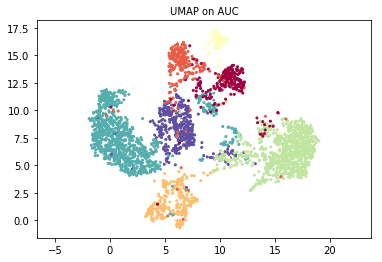

In [31]:
plot_dr(dr_umap.values, title='UMAP on AUC', cellLabels=cell_annotations['level1class']) 

##### t-SNE

In [32]:
from sklearn.manifold import TSNE

In [33]:
%%time
dr_tsne = TSNE(n_components=2).fit_transform(auc_mtx)
dr_tsne = pd.DataFrame(data=dr_tsne, index=auc_mtx.index, columns=['tSNE_X', 'tSNE_Y'])
dr_tsne.to_csv(TSNE_FNAME, index=True, sep='\t')

CPU times: user 37.7 s, sys: 523 ms, total: 38.2 s
Wall time: 25.1 s


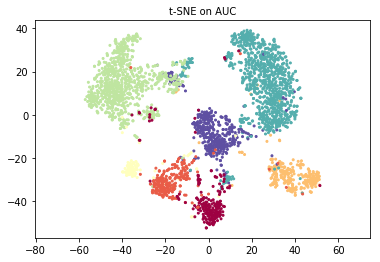

In [34]:
plot_dr(dr_tsne.values, title='t-SNE on AUC', cellLabels=cell_annotations['level1class'])

#### Save the loom file...

In [36]:
# embeddings=dr_umap
embeddings=pd.concat([dr_tsne, dr_umap], axis=1, join='outer')

In [ ]:
export2loom(ex_mtx=ex_matrix,
            regulons=regulons,
            out_fname=LOOM_FNAME, 
            cell_annotations=cell_annotations,
            cell_clusters=cell_clusters,
            title=loom_title, 
            nomenclature=ORGANISM, 
            tree_structure=loom_tree_structure,
            num_workers=48, 
            embeddings=embeddings,
            auc_mtx=auc_mtx, 
            auc_thresholds=None,
            compress=True)

####  Reading a loom file
To read the contents of the loom file see [loompy](http://linnarssonlab.org/loompy/):

In [11]:
# loom=loompy.connect(LOOM_FNAME)
# from pyscenic.export import decompress_meta
# decompress_meta(loom.attrs["MetaData"])['regulonThresholds'][:3]

## Visualization and exploring AUCell results (e.g. regulon activity)

#### Binarization of AUC
(Default thresholds are also calculated by the function export2loom)

In [21]:
from pyscenic.binarization import binarize
auc_binary, auc_thresholds = binarize(auc_mtx)
auc_binary.iloc[:5,:5]
auc_thresholds[:5]

Regulon,1810024B03Rik (52g),Abl1 (13g),Acaa1a (43g),Acaa1b (60g),Ahr (9g)
1772071015_C02,0,0,0,1,0
1772071017_G12,0,1,0,1,0
1772071017_A05,0,1,0,1,0
1772071014_B06,0,0,0,1,0
1772067065_H06,0,1,0,1,0


Regulon
1810024B03Rik (52g)     [0.004494794294892294]
Abl1 (13g)             [0.0022078584566364435]
Acaa1a (43g)              [0.1025057087359952]
Acaa1b (60g)             [0.05016871738037472]
Ahr (9g)                [0.002049002410065136]
dtype: object

#### Visualization as heatmap

In [22]:
import seaborn as sns 
sns.clustermap(auc_binary.T, figsize=(10,10), cmap=sns.cm.rocket_r)

#### Activity distribution within a regulon (histograms)

In [23]:
import matplotlib.pyplot as plt
def plot_AUC(auc_mtx: pd.DataFrame, regulon_name: str, threshold: float=None, bins: int=200, ax=None) -> None:
    """
    Plot the AUC distribution for the given regulon.

    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param regulon_name: The name of the regulon.
    :param bins: The number of bins to use in the AUC histogram.
    :param threshold: The threshold to use for binarization.
    """
    if ax is None:
        ax=plt.gca()
    auc_mtx[regulon_name].hist(bins=bins,ax=ax)

    ylim = ax.get_ylim()
    if not threshold is None:
        ax.plot([threshold]*2, ylim, 'r:')
    ax.set_ylim(ylim)
    ax.set_xlabel('AUC')
    ax.set_ylabel('#')
    ax.set_title(regulon_name)

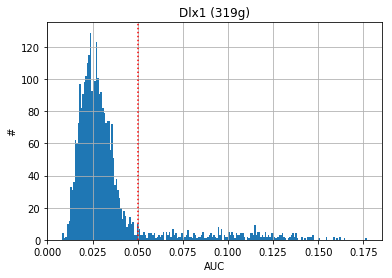

In [24]:
plot_AUC(auc_mtx, "Dlx1 (319g)", threshold=0.05)

#### Exploring the regulatory network (regulons and motif enrichment)

Some examples for exploring the output: 

In [61]:
# Subsetting the regulons:
from pyscenic.genesig import regulonSizes, regulonNames, regulonGenes
regulonSizes(regulons[:5])
regulonNames(regulons[:5])
regulonGenes(regulons, 'Dlx1 (319g)')[:5]

{'1810024B03Rik (52g)': 52,
 'Abl1 (13g)': 13,
 'Acaa1a (43g)': 43,
 'Acaa1b (60g)': 60,
 'Ahr (9g)': 9}

{'1810024B03Rik (52g)': 0,
 'Abl1 (13g)': 1,
 'Acaa1a (43g)': 2,
 'Acaa1b (60g)': 3,
 'Ahr (9g)': 4}

['Elavl2', 'Btbd11', 'Dlx6os1', 'Cnr1', 'Vstm2a']

In [15]:
# Motifs supporting the regulons of a given TF:
motifEnr.loc[('Sox10')][:3]

Enrichment            \
                                                   NES       AUC   
MotifID                                                            
cisbp__M1604                                  3.283942  0.048426   
taipale_cyt_meth__SOX4_GAACAAAGRN_eDBD_repr   3.052460  0.047111   
cisbp__M1597                                  3.135895  0.047585   

                                                                   \
                                            MotifSimilarityQvalue   
MotifID                                                             
cisbp__M1604                                             0.000640   
taipale_cyt_meth__SOX4_GAACAAAGRN_eDBD_repr              0.000048   
cisbp__M1597                                             0.000115   

                                                                 \
                                            OrthologousIdentity   
MotifID                                                           
cisbp__M1604                                                1.0   
taipale_cyt_meth__SOX4_GAACAAAGRN_eDBD_repr                 1.0   
cisbp__M1597                                                1.0   

                                                                                                \
                                                                                    Annotation   
MotifID                                                                                          
cisbp__M1604                                 motif similar to hocomoco__SOX10_MOUSE.H11MO.1...   
taipale_cyt_meth__SOX4_GAACAAAGRN_eDBD_repr  motif similar to hocomoco__SOX10_MOUSE.H11MO.1...   
cisbp__M1597                                 gene is annotated for similar motif cisbp__M15...   

                                                                                                \
                                                                                       Context   
MotifID                                                                                          
cisbp__M1604                                 (activating, mm9-500bp-upstream-7species, weig...   
taipale_cyt_meth__SOX4_GAACAAAGRN_eDBD_repr  (activating, mm9-500bp-upstream-7species, weig...   
cisbp__M1597                                 (activating, mm9-500bp-upstream-7species, weig...   

                                                                                                \
                                                                                   TargetGenes   
MotifID                                                                                          
cisbp__M1604                                 [(Ermn, 1.1847846328388143), (Lrrn1, 2.8130722...   
taipale_cyt_meth__SOX4_GAACAAAGRN_eDBD_repr  [(Tmeff1, 1.1847846328388143), (Ing1, 2.813072...   
cisbp__M1597                                 [(Rims2, 1.1847846328388143), (Dmrta2, 2.81307...   

                                                       \
                                            RankAtMax   
MotifID                                                 
cisbp__M1604                                      847   
taipale_cyt_meth__SOX4_GAACAAAGRN_eDBD_repr       547   
cisbp__M1597                                     1492   

                                                                                                
                                                                                      MotifURL  
MotifID                                                                                         
cisbp__M1604                                 http://motifcollections.aertslab.org/v9/logos/...  
taipale_cyt_meth__SOX4_GAACAAAGRN_eDBD_repr  http://motifcollections.aertslab.org/v9/logos/...  
cisbp__M1597                                 http://motifcollections.aertslab.org/v9/logos/...